In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15,3)
from IPython.display import display

In [2]:
import numpy as np

In [3]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

---

Use some matrix... just check if it trains and if so how quickly

In [4]:
from movieLensAnalyzer import MovieLensAnalyzer 
movieLensAnalyzer = MovieLensAnalyzer()
R_train = movieLensAnalyzer.trainRatingMatrix
R_test = movieLensAnalyzer.testRatingMatrix
R = R_train + R_test

In [5]:
np.sum(R>0)

100000

---

Maybe our problem is due to the matrix being too sparse. Let's DESPARSIFY by dropping some sparse rows and/or columns.

In [6]:
print("% of items: ", np.sum(R > 0) / (R.shape[0] * R.shape[1]))

R_dense = np.copy(R)
MIN_PERC_FILLED = 0.3

idx = []
# Remove items
for j in range(R_dense.shape[1]):
    perc_filled = np.sum(R_dense[:,j] > 0) / R_dense.shape[0]
    if perc_filled >= MIN_PERC_FILLED:
        idx.append(j)
R_dense = R_dense[:, idx]
R_dense.shape

idx = []
# Remove users
for i in range(R_dense.shape[0]):
    perc_filled = np.sum(R_dense[i,:] > 0) / R_dense.shape[1]
    if perc_filled >= MIN_PERC_FILLED:
        idx.append(i)
R_dense = R_dense[idx, :]
R_dense.shape

print("% of items: ", np.sum(R_dense > 0) / (R_dense.shape[0] * R_dense.shape[1]))

% of items:  0.0630466936422
% of items:  0.555527743012


In [7]:
R = R_dense

---

The point of this is to check that if we can fine-tune a model and still obtain meaningful uncertainty **updates** per user.

First, we pick a significant amount of users to check.

In [8]:
NUM_USERS_DENSE = 20
NUM_USERS_SPARS = 100
PERC_DROP = 0.3 # approximately.

In [9]:
R.shape

(510, 47)

In [10]:
rating_density_per_user = list(zip(np.sum(R>0, axis=1), range(R.shape[0])))
dense_users = sorted(rating_density_per_user, key=lambda x: -x[0])[:NUM_USERS_DENSE]
spars_users = sorted(rating_density_per_user, key=lambda x:  x[0])[:NUM_USERS_SPARS]

In [11]:
train_mask = R > 0

# The test masks we'll use later.
test_masks = {}

# We artifically dropout some elements from the users we're interested in. Assume the rest of the matrix is filled.
np.random.seed(1337)
for _, idx in (dense_users + spars_users):
    before = np.copy(train_mask[idx, :])
    
    dropout = 1-np.random.binomial(1, PERC_DROP, size=R.shape[1])
    train_mask[idx, :] = dropout * train_mask[idx, :]
    
    test_mask = np.bitwise_xor(before, train_mask[idx, :])
    test_masks[idx] = test_mask

In [12]:
# sanity check
print(np.sum(train_mask))
print(np.sum([np.sum(m) for _, m in test_masks.items()]))

12552
764


---

Our NNMF model.

We train it once a lot of iterations (2000 by default), which is pretty much convergence.

Edit: Training till 2000, each finetune is not showing any improvement in entropy. This can be either because:
- Each finetuning steps is not trained enough (I don't have enough compute power to explore this)
- Or it's stuck at a local minima; we can try training less iterations at the beginning.

TODO:
- Check how much entropy is going down over the iterations while the model is training. I wonder if it's going down at all, and where it gets stuck!

In [13]:
from pmf import PMF
model = PMF(ratingMatrix=R)

In [14]:
# get user entropy
from empirical_entropy import empirical_entropy
def get_entropy_data(model, user_index, intended_mask, num_samples=1000):
    samples = model.sample_for_user(user_index, num_samples)
    _, per_item_entropy = empirical_entropy(samples)
    mean_all_entropy = np.mean(per_item_entropy[np.where(R[user_index,:] > 0)]) # all items we could see
    mean_intended_entropy = np.mean(per_item_entropy[np.where(intended_mask)]) # just elements we meant to test on
    return mean_all_entropy, mean_intended_entropy

## EXP BEGIN

In [15]:
model.save('start.ckpt')

'start.ckpt'

In [16]:
def plot_R(rhats, r=None, title=''):
    _, n_items = rhats.shape
    f, axes = plt.subplots(1, n_items, sharex=True, sharey=True)
    i = 0
    for j in range(n_items):
        if r is not None:
            axes[j].axvline(x=r[j], color='r', alpha=0.4)
        axes[j].hist(rhats[:,j], histtype='stepfilled', normed=True)
    #plt.xlim([0,6])
    f.suptitle(title)
    plt.show()

In [17]:
model.load('start.ckpt')

INFO:tensorflow:Restoring parameters from start.ckpt


In [18]:
entropy_data = []
user = spars_users[0][1] #dense_users[0][1]

In [19]:
import tensorflow as tf

In [20]:
with model.sess.as_default() as sess:
    display(tf.trainable_variables())

[<tf.Variable 'Variable:0' shape=(510, 20) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(510, 20) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(47, 20) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(47, 20) dtype=float32_ref>]

In [21]:
def joint_entropy(vars):
    marginal_entropy = 0.5*np.log(2*np.pi*np.e*vars)
    joint_entropy = np.sum(vars, axis=1)
    return joint_entropy

def get_latents_entropy(model):
    with model.sess.as_default() as sess:
        #display(tf.trainable_variables())
        #qU_m = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[0])
        qU_v = sess.run(tf.nn.softplus(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[1]))
        #qV_m = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[2])
        qV_v = sess.run(tf.nn.softplus(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[3]))
        
        qU_entropy = joint_entropy(qU_v)
        qV_entropy = joint_entropy(qV_v)
        return qU_entropy, qV_entropy

In [22]:
def debug(iteration, user):
    print("Iteration {}".format(iteration))
    samples = model.sample_for_user(user, 100)
    test_samples = samples[:,np.squeeze(np.where(test_masks[user]))]
    trin_samples = samples[:,np.squeeze(np.where(train_mask[user,:]))]
    print(user)
    plot_R(test_samples[:,:5], title='Test Samples')
    plot_R(trin_samples[:,:5], title='Trin Samples')

    if iteration > -100:
        entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
        plt.plot([x[0] for x in entropy_data], label='mean all')
        plt.plot([x[1] for x in entropy_data], label='mean test')
        plt.legend()
        plt.title('entropy so far')
        _ = plt.show()

        qU_entropy, qV_entropy = get_latents_entropy(model)
        #print("LATENTS ENTROPY: {}".format(latents_entropy))

        _ = plt.hist(qU_entropy, bins=100, histtype='stepfilled')
        plt.title('qU_entropy')
        plt.show()

        _ = plt.hist(qV_entropy, bins=100, histtype='stepfilled')
        plt.title('qV_entropy')
        plt.show()

Iteration -1
22


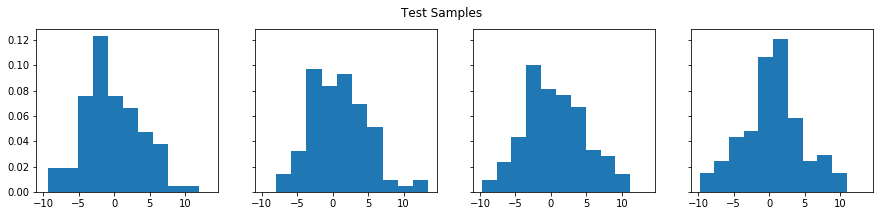

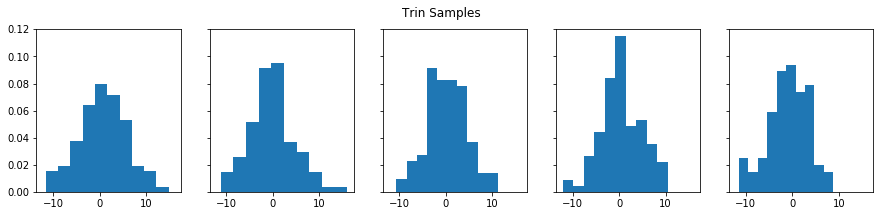

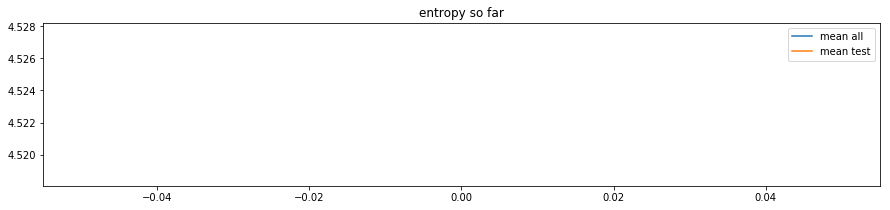

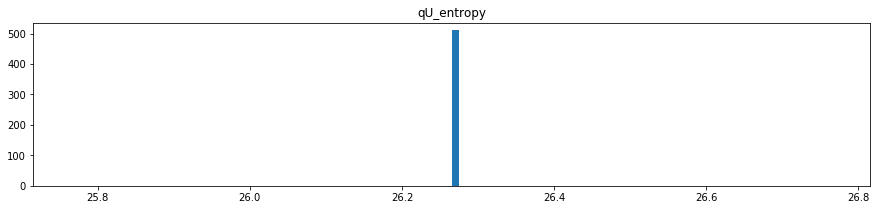

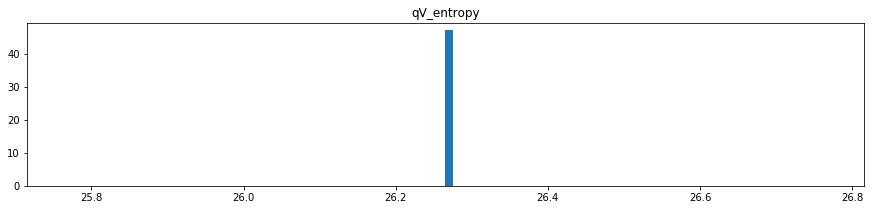

CPU times: user 4.77 s, sys: 1.32 s, total: 6.09 s
Wall time: 2.93 s
Iteration 0
22


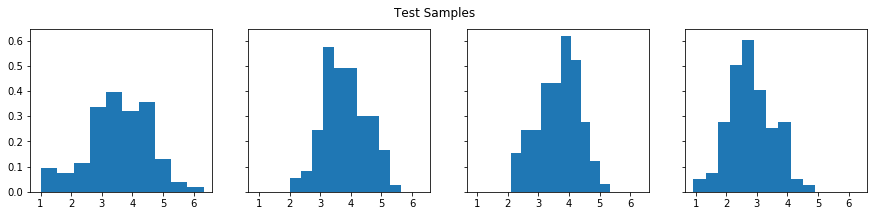

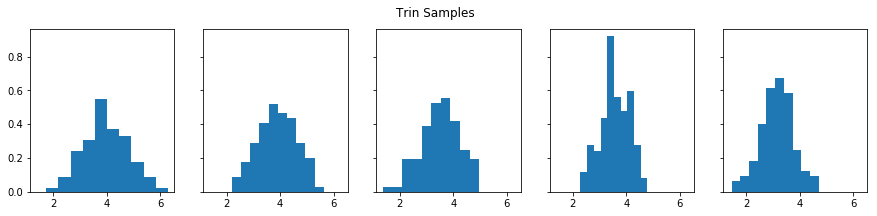

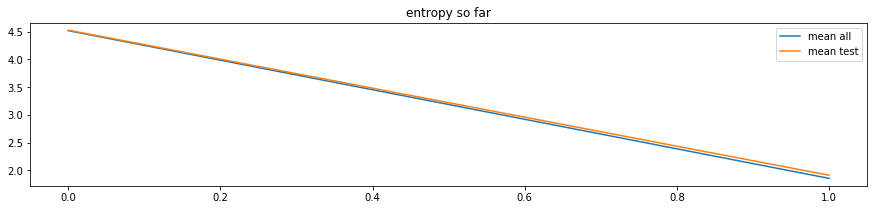

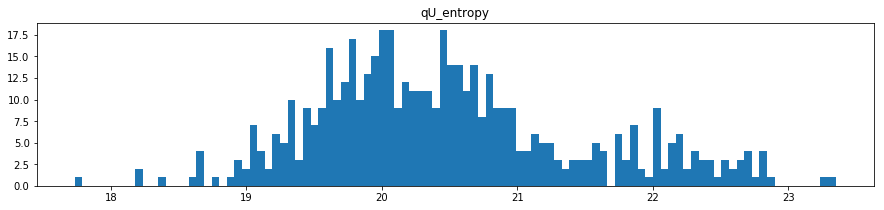

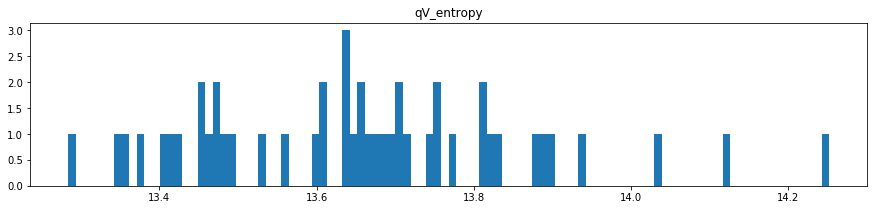

CPU times: user 4.57 s, sys: 1.02 s, total: 5.58 s
Wall time: 3.02 s
Iteration 1
22


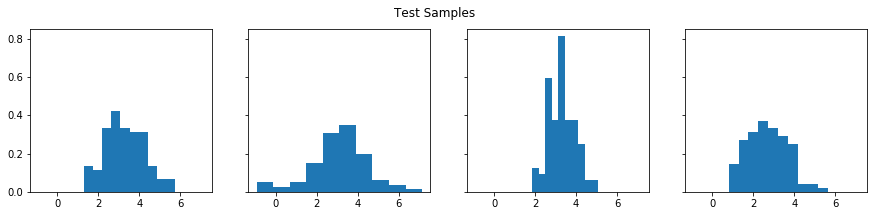

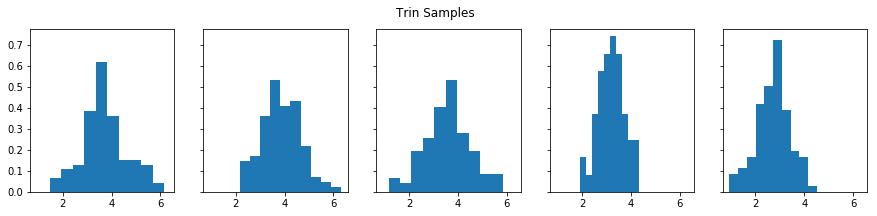

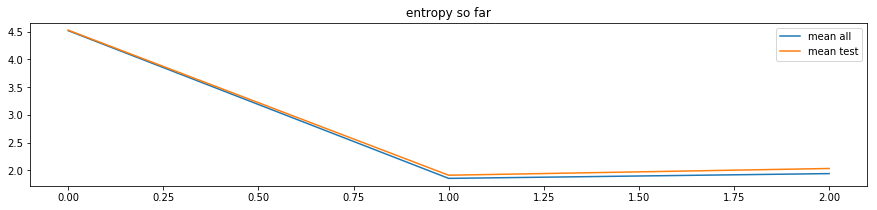

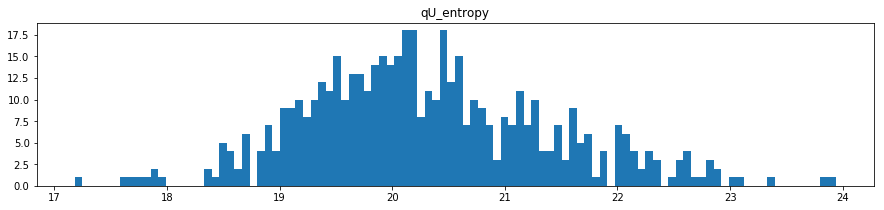

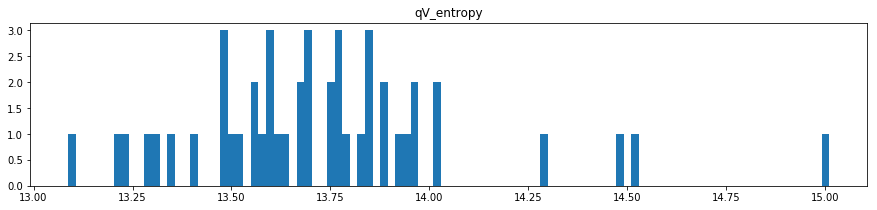

CPU times: user 4.53 s, sys: 1.12 s, total: 5.65 s
Wall time: 2.76 s
Iteration 2
22


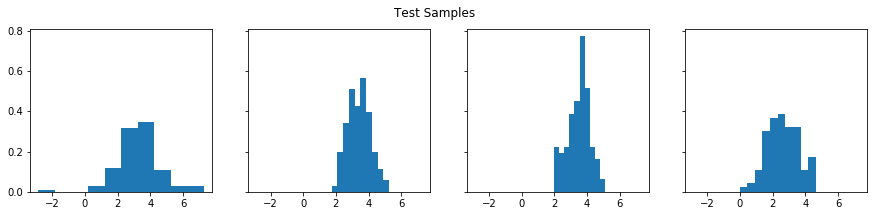

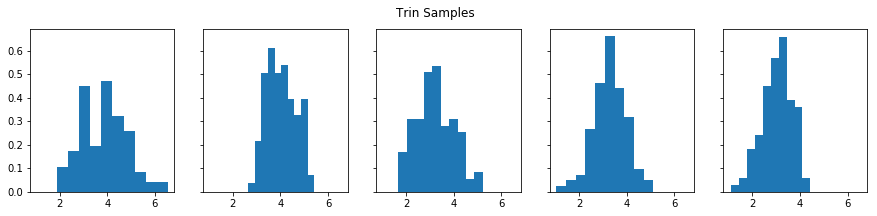

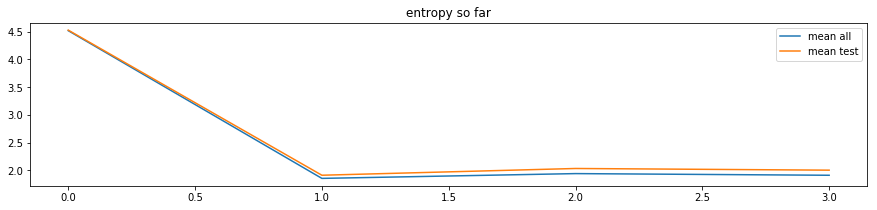

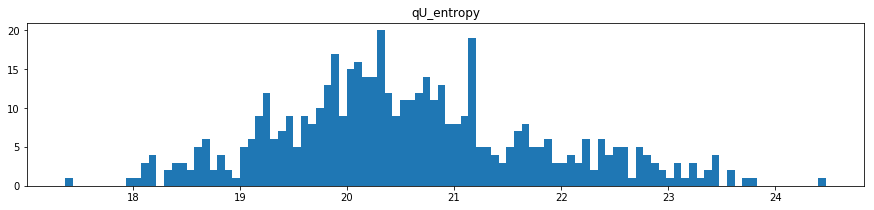

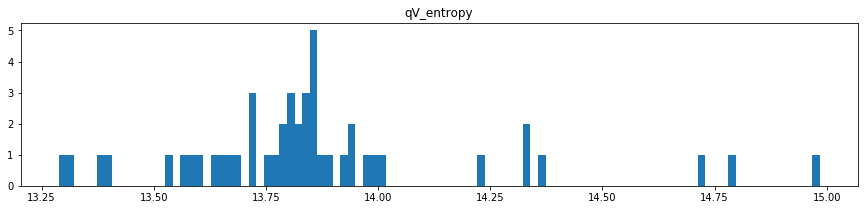

CPU times: user 4.46 s, sys: 1.17 s, total: 5.62 s
Wall time: 2.49 s
Iteration 3
22


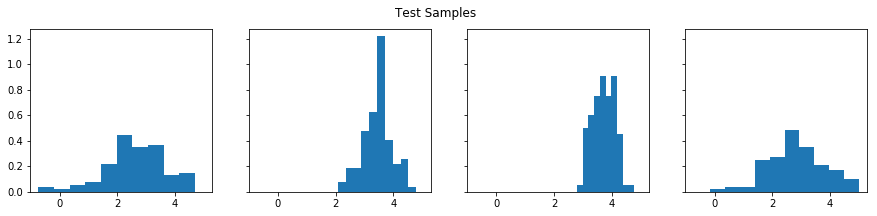

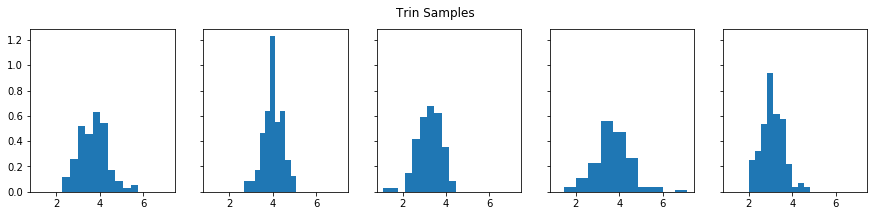

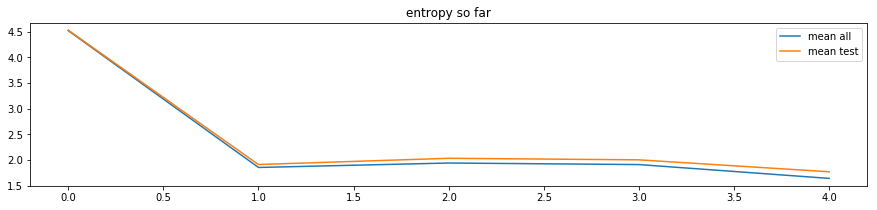

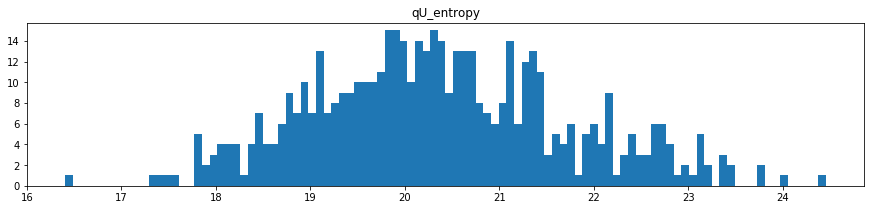

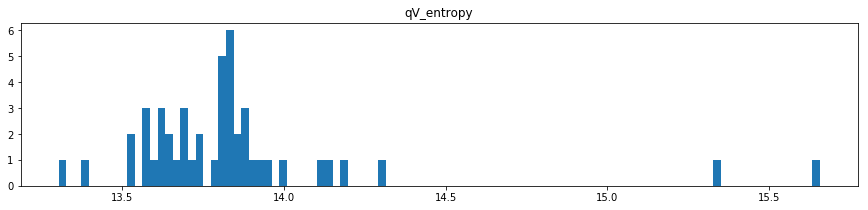

CPU times: user 4.54 s, sys: 988 ms, total: 5.52 s
Wall time: 2.93 s
Iteration 4
22


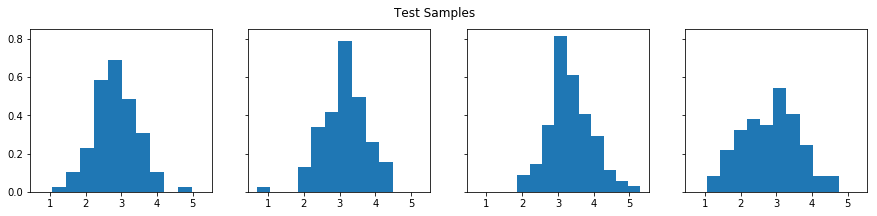

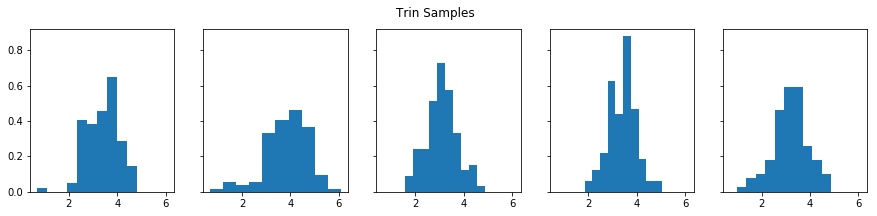

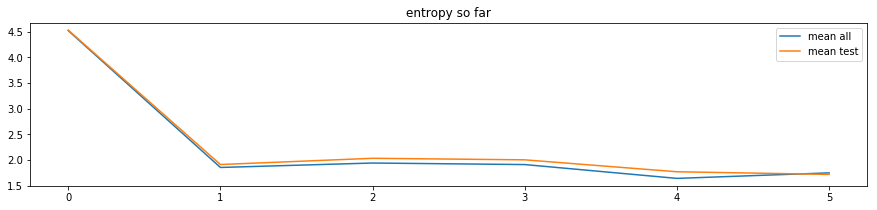

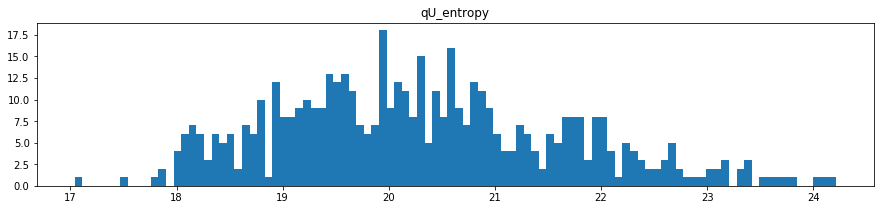

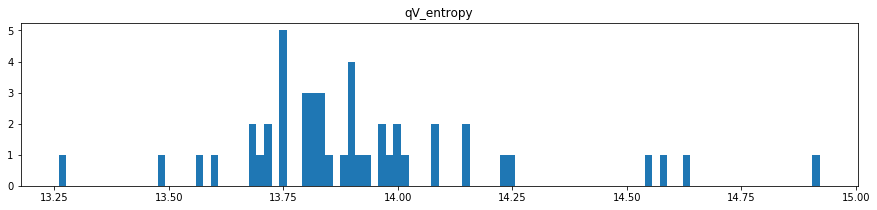

CPU times: user 4.39 s, sys: 1.05 s, total: 5.44 s
Wall time: 2.81 s
Iteration 5
22


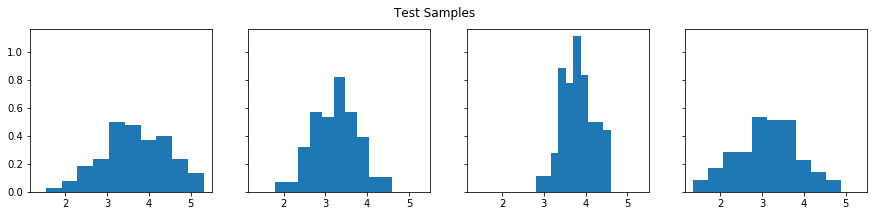

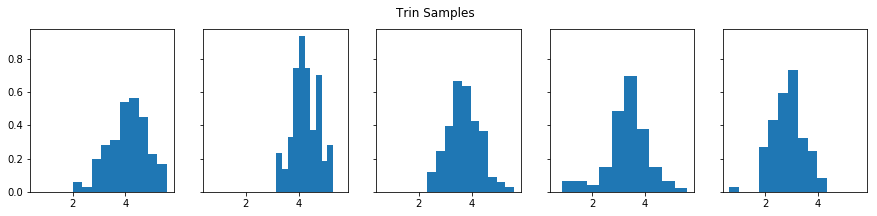

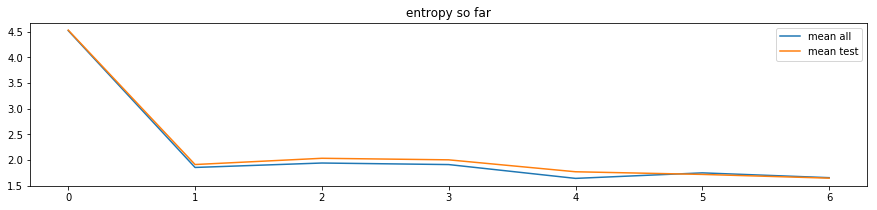

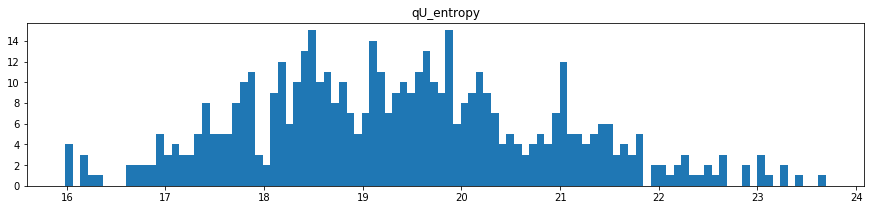

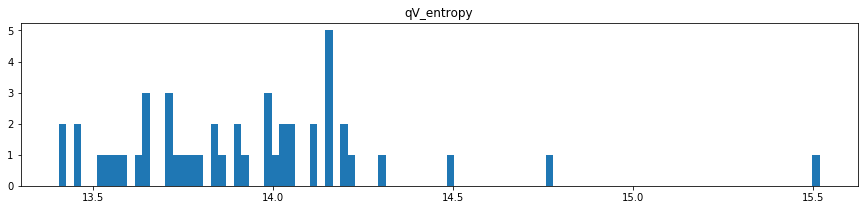

CPU times: user 4.59 s, sys: 1.01 s, total: 5.6 s
Wall time: 3.58 s
Iteration 6
22


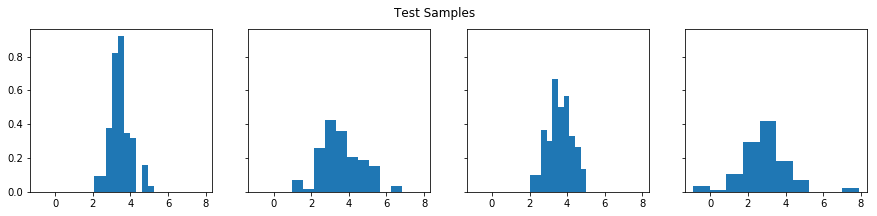

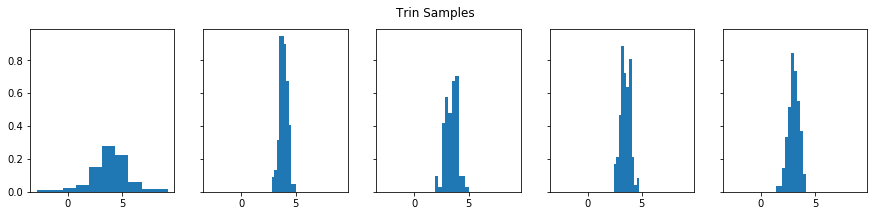

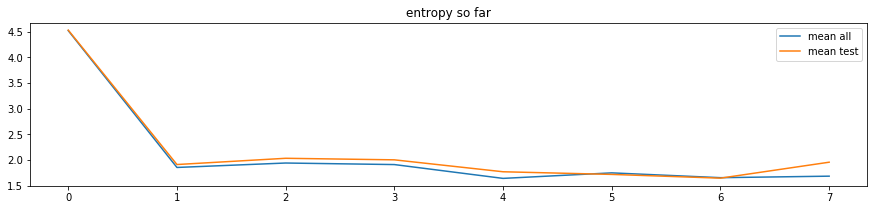

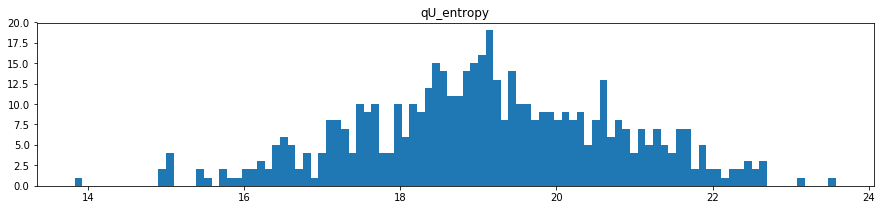

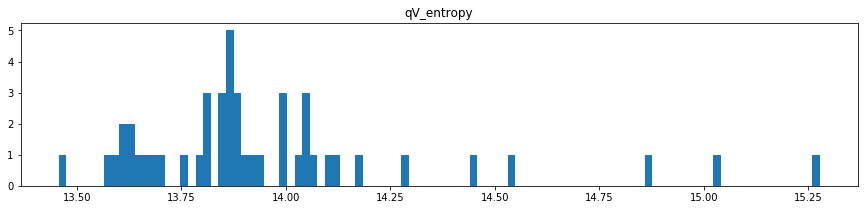

CPU times: user 4.31 s, sys: 942 ms, total: 5.25 s
Wall time: 3.09 s
Iteration 7
22


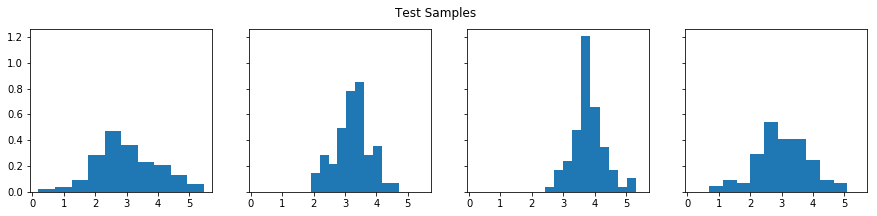

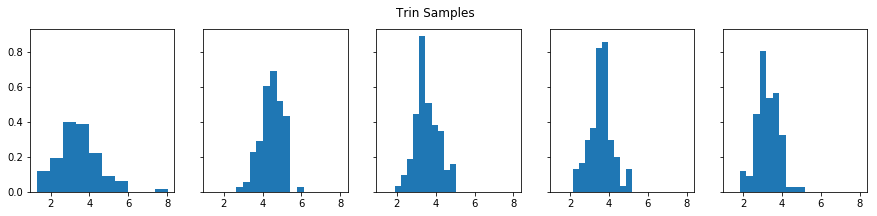

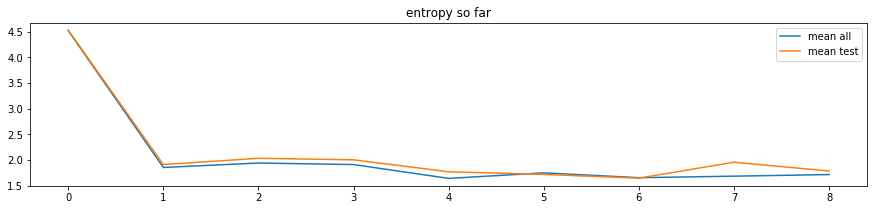

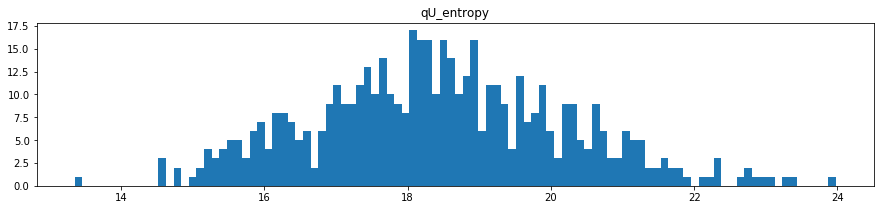

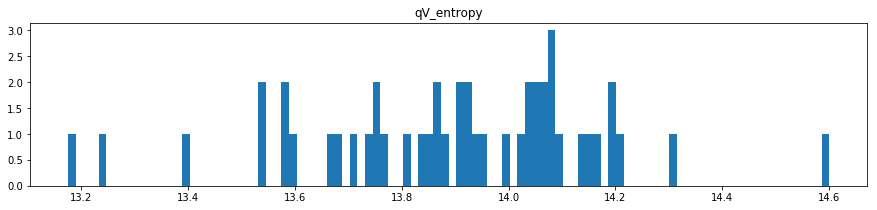

CPU times: user 4.16 s, sys: 863 ms, total: 5.02 s
Wall time: 3.31 s
Iteration 8
22


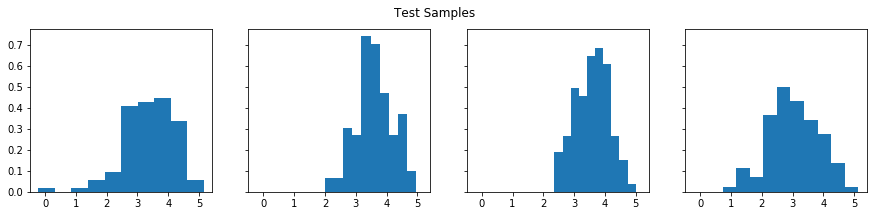

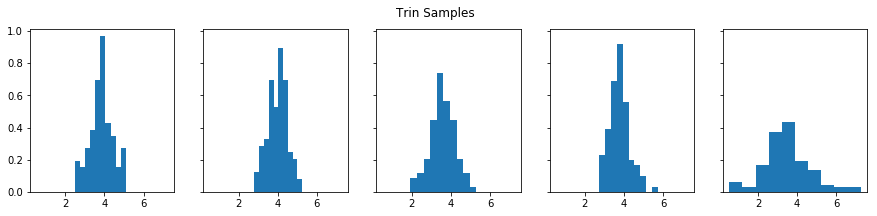

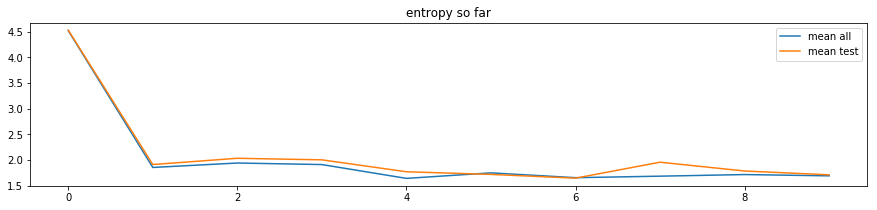

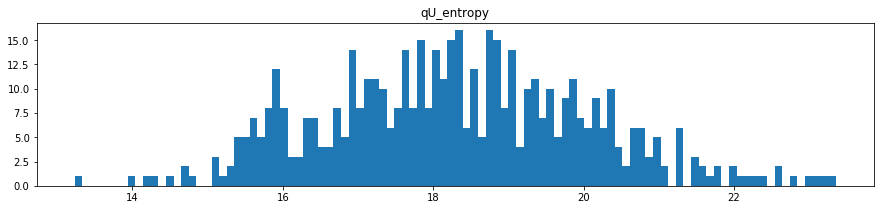

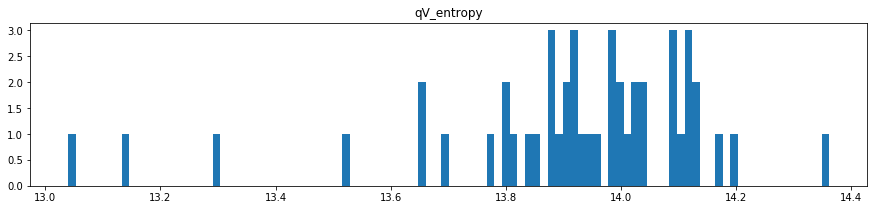

CPU times: user 4.64 s, sys: 983 ms, total: 5.62 s
Wall time: 3.36 s
Iteration 9
22


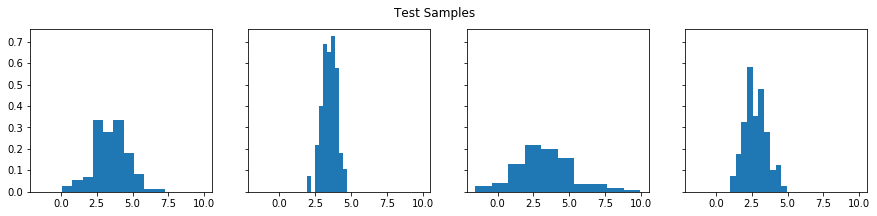

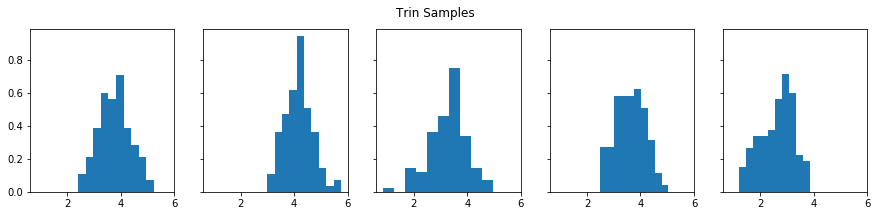

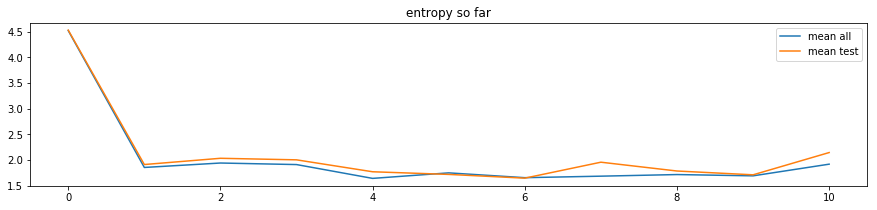

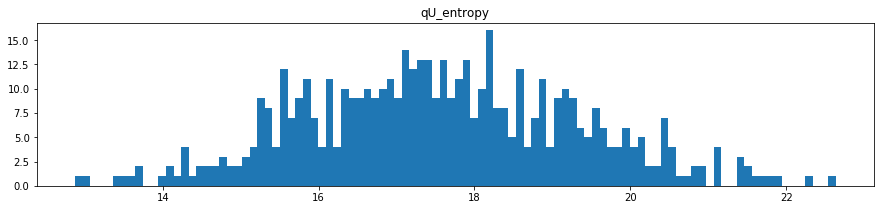

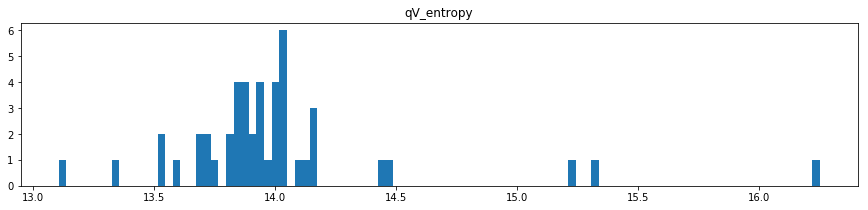

CPU times: user 4.74 s, sys: 1.09 s, total: 5.83 s
Wall time: 3.61 s
Iteration 10
22


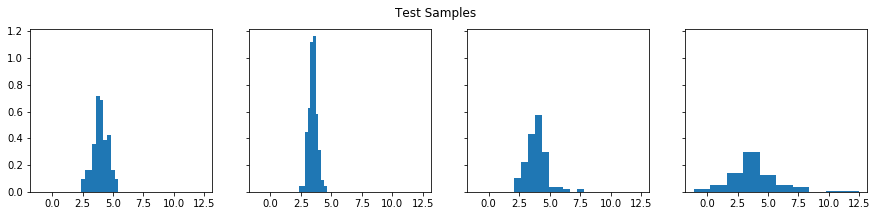

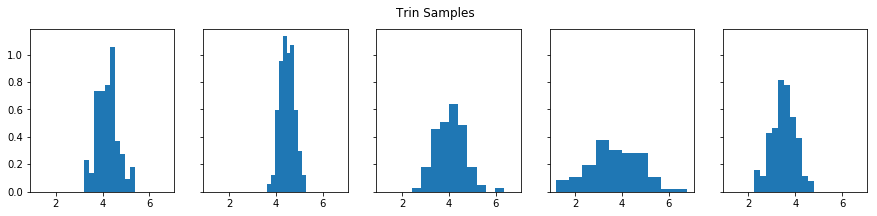

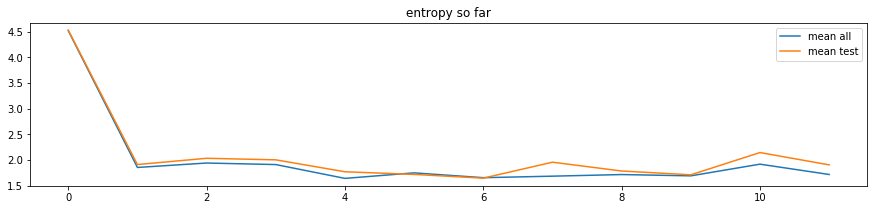

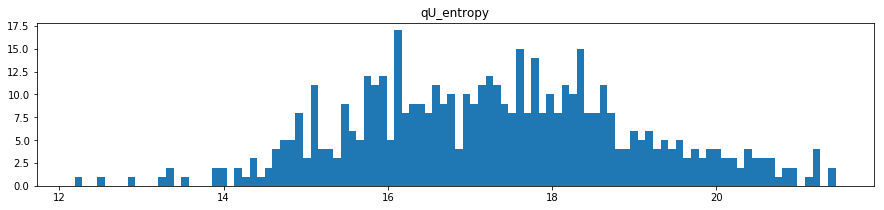

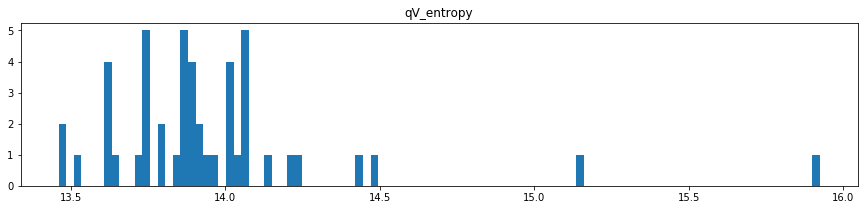

CPU times: user 4.52 s, sys: 1.1 s, total: 5.62 s
Wall time: 3.41 s
Iteration 11
22


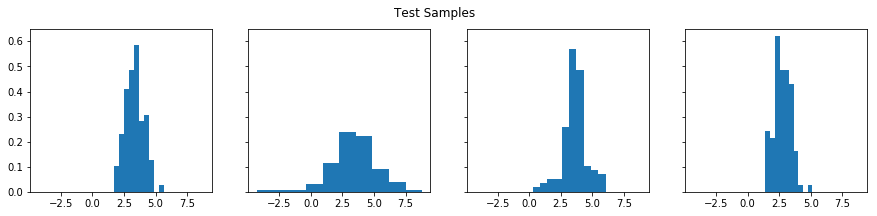

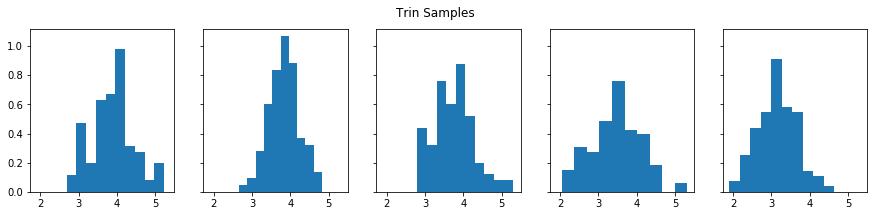

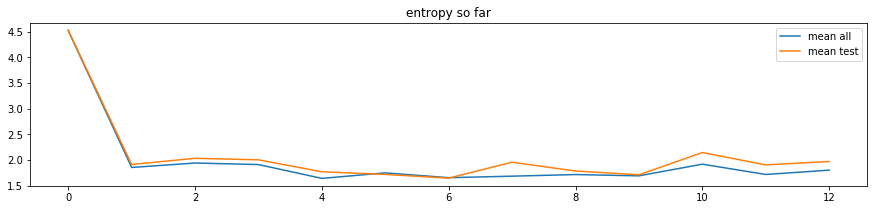

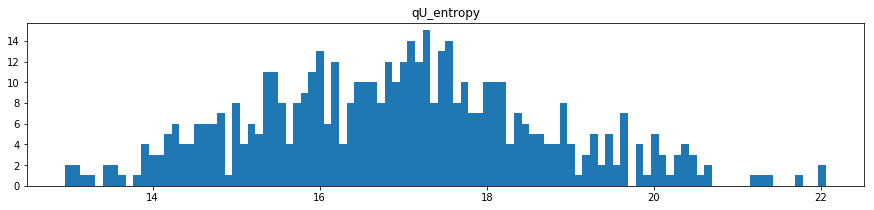

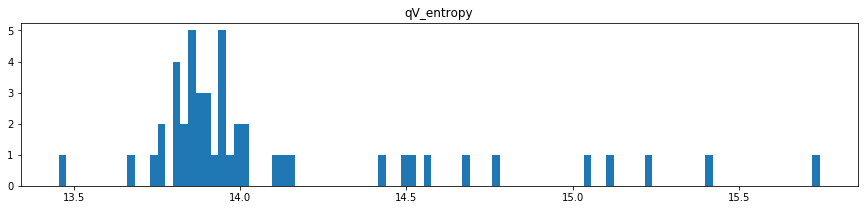

CPU times: user 4.35 s, sys: 831 ms, total: 5.18 s
Wall time: 3.36 s
Iteration 12
22


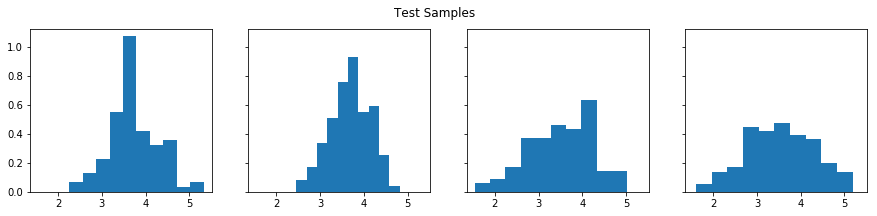

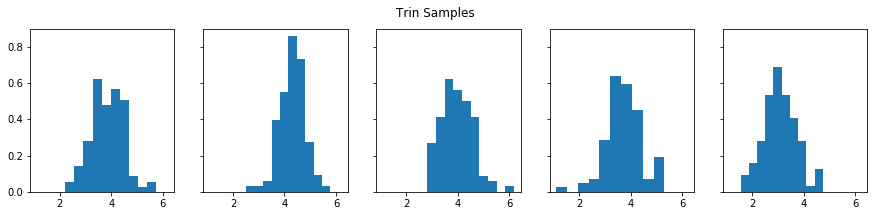

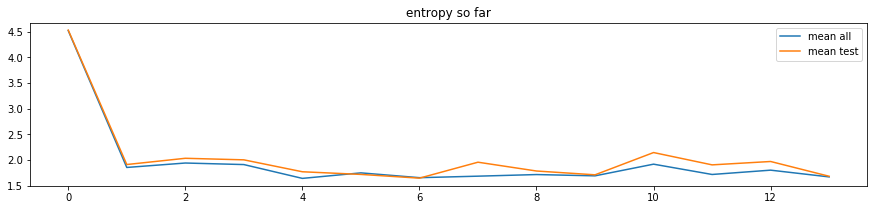

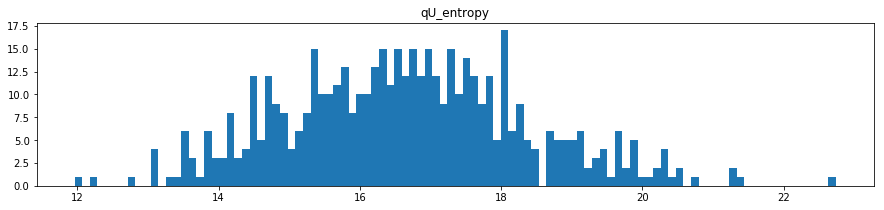

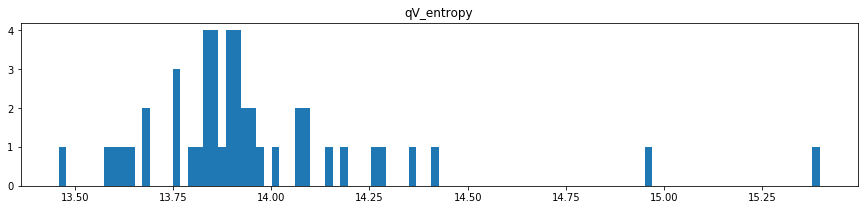

CPU times: user 4.69 s, sys: 1.02 s, total: 5.71 s
Wall time: 3.47 s
Iteration 13
22


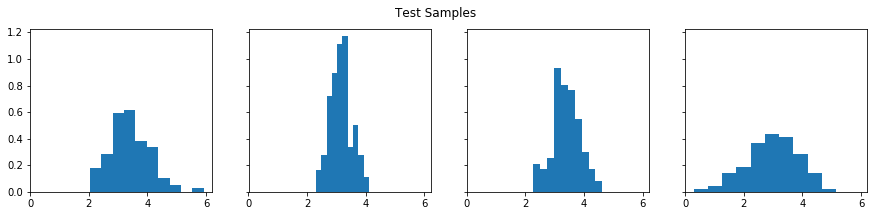

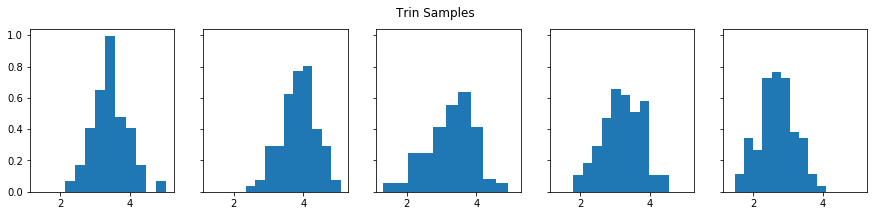

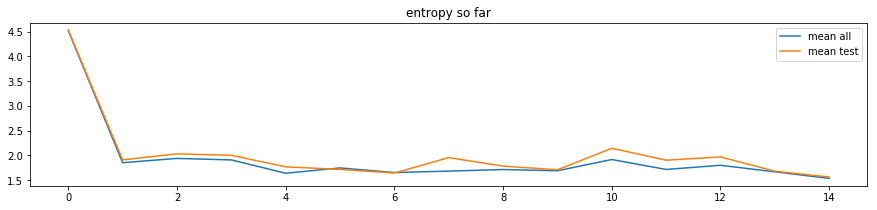

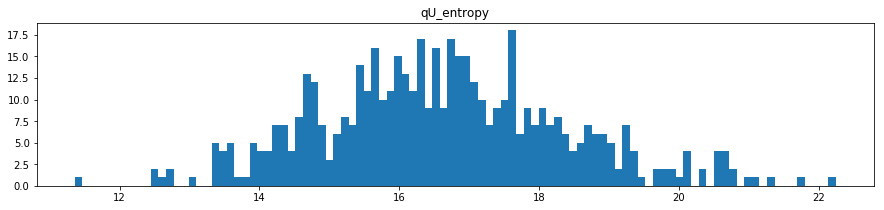

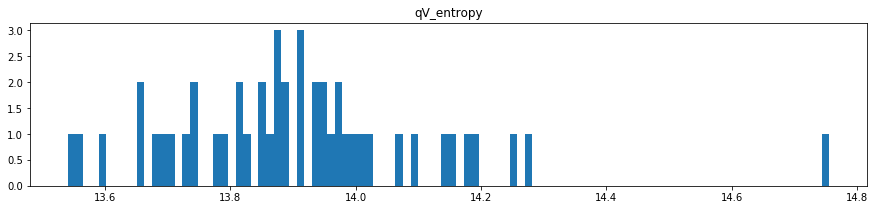

CPU times: user 4.55 s, sys: 1.03 s, total: 5.57 s
Wall time: 2.95 s
Iteration 14
22


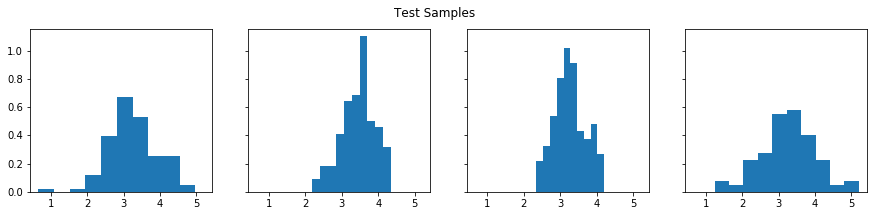

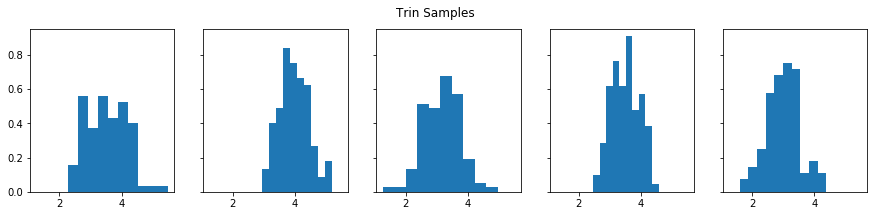

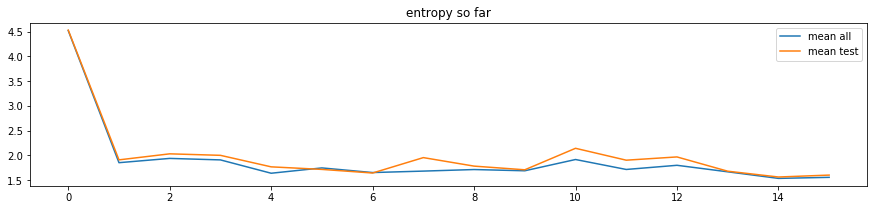

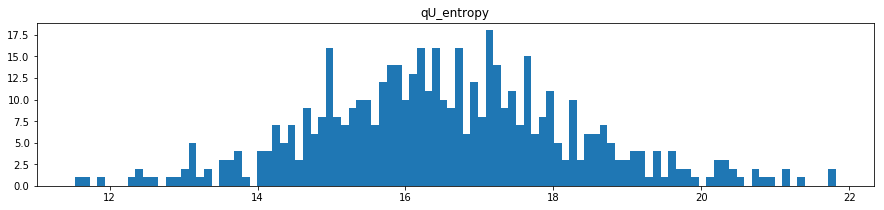

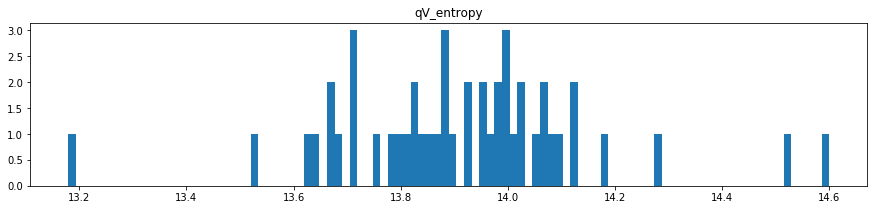

In [23]:
debug(-1, user)
for i in range(15):
    %time losses = model.train(train_mask, n_iter=200)
    debug(i, user)

---

In [71]:
dense_users[:5]

[(737, 404), (685, 654), (636, 12), (540, 449), (518, 275)]

In [70]:
spars_users[:5]

[(20, 18), (20, 33), (20, 35), (20, 92), (20, 142)]

404
Iteration -1000


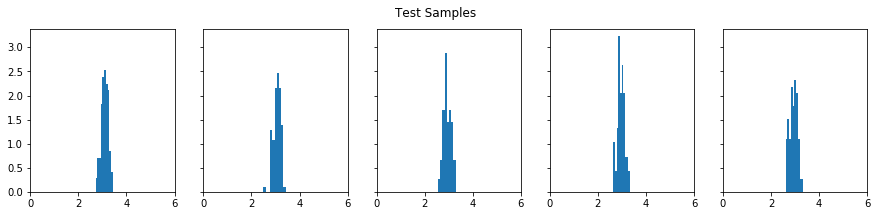

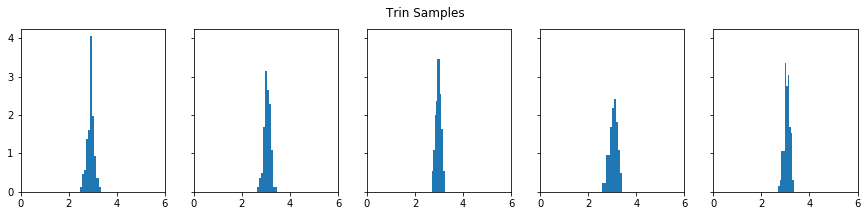

654
Iteration -1000


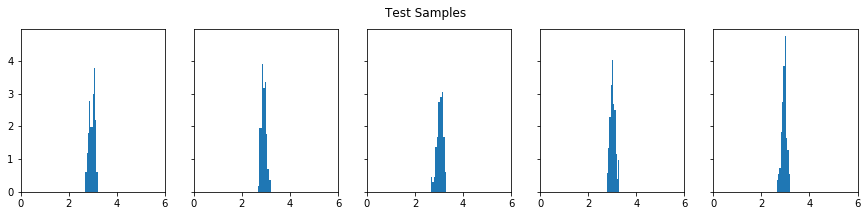

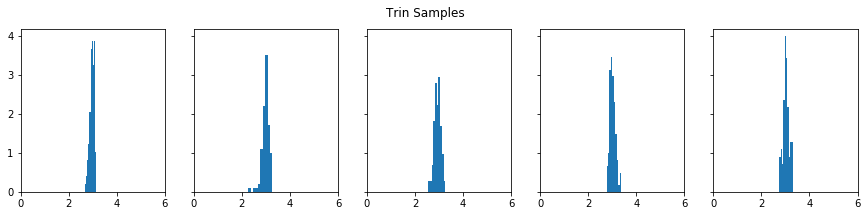

12
Iteration -1000


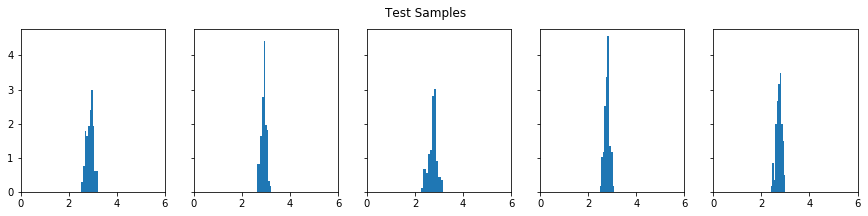

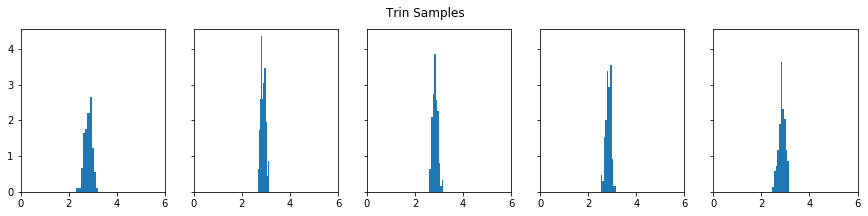

449
Iteration -1000


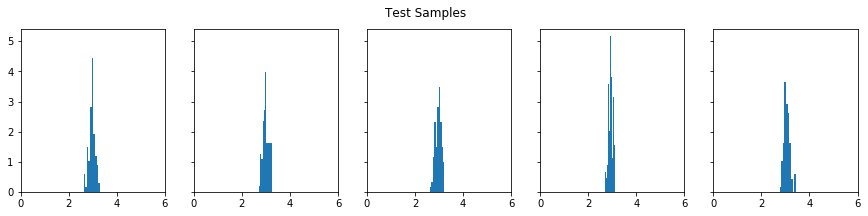

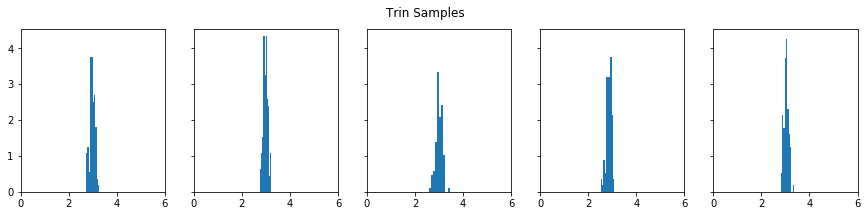

275
Iteration -1000


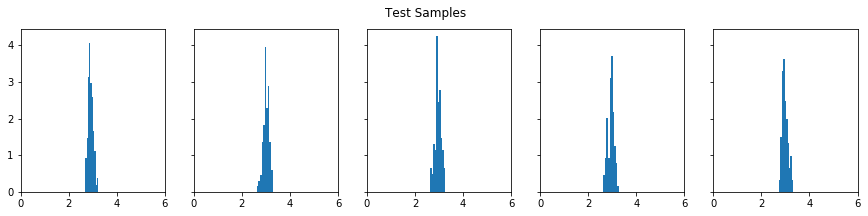

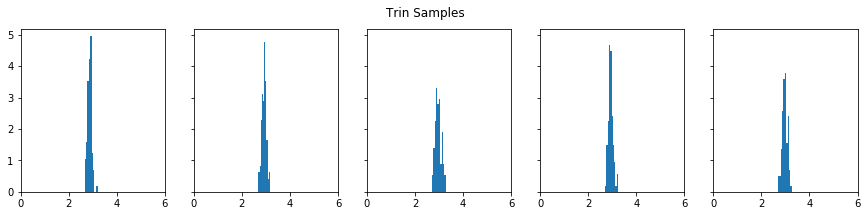

In [76]:
for u in dense_users[:5]:
    print(u[1])
    debug(-1000, u[1])

18
Iteration -1000


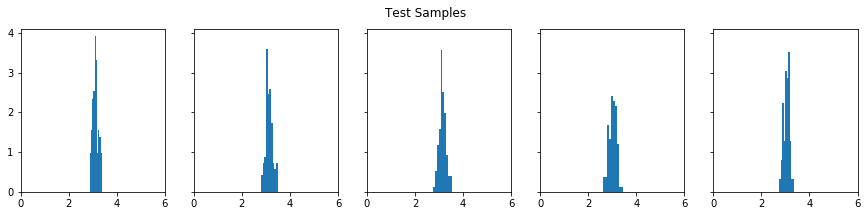

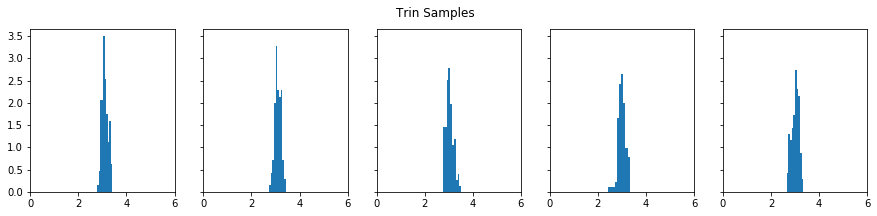

33
Iteration -1000


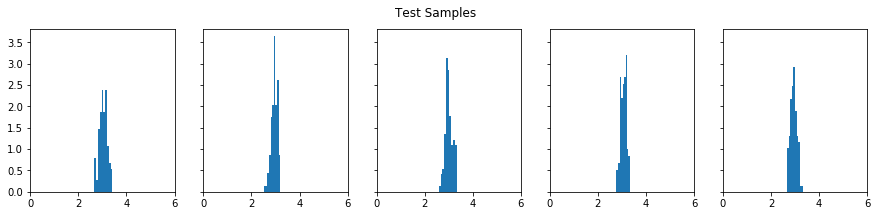

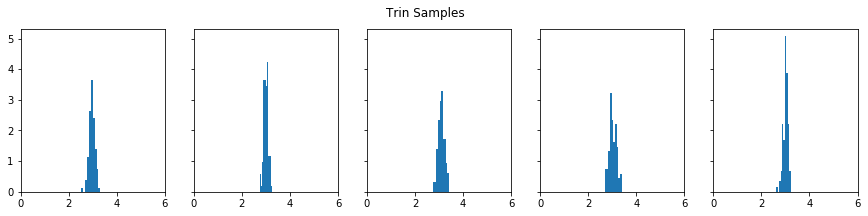

35
Iteration -1000


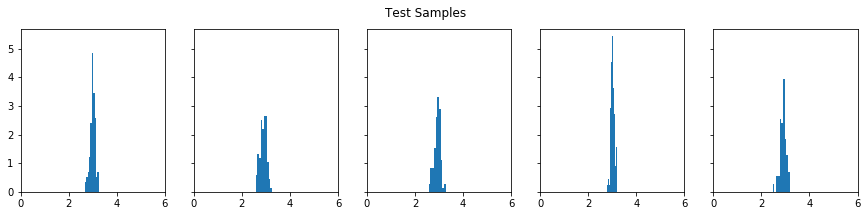

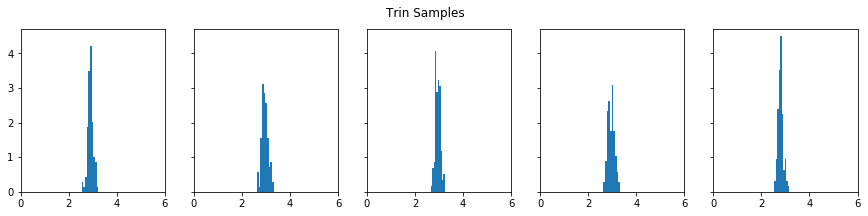

92
Iteration -1000


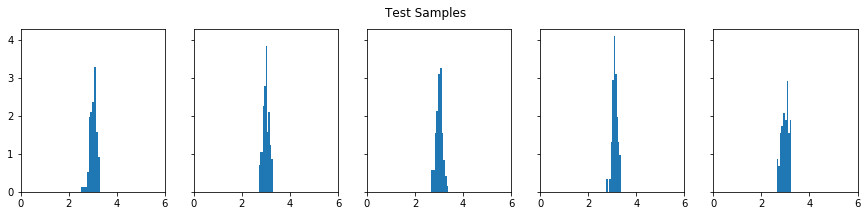

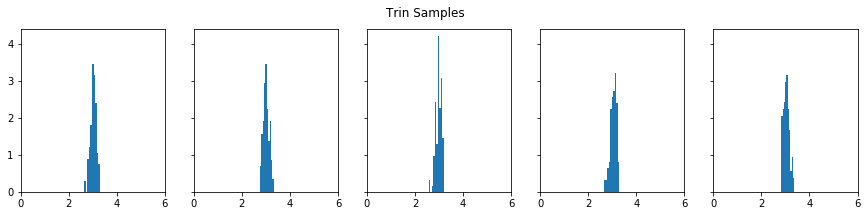

142
Iteration -1000


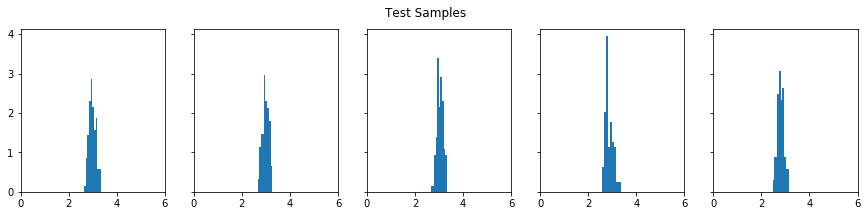

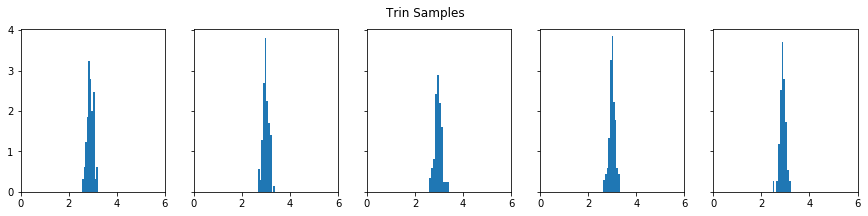

In [77]:
for u in spars_users[:5]:
    print(u[1])
    debug(-1000, u[1])

## EXP END

In [12]:
%time losses = model.train(train_mask, n_iter=100)

CPU times: user 1min 16s, sys: 12.4 s, total: 1min 28s
Wall time: 27.7 s


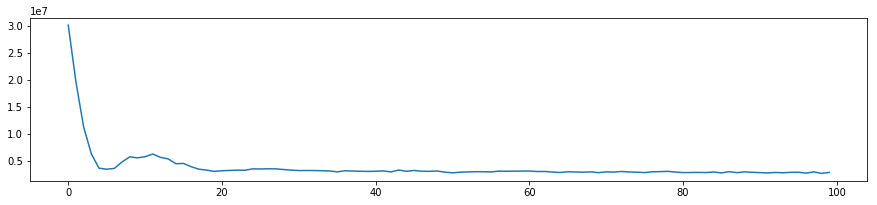

In [13]:
_ = plt.plot(losses)

In [14]:
checkpoing_fname = 'test_checkpoing_100.ckpt'
model.save(checkpoing_fname)

'test_checkpoing_100.ckpt'

We checkpoint this initially trained model, then:

```
N = some small number (eg. 100)

For each user u:
    reset mask
    for each unseen item i:
        update mask
        reload model
        show item i to user u, finetune model on mask with N steps
        measure how much the posterior changed (eg. via entropy)
```

In [16]:
N_STEPS_FINETUNE = 200 # 20 doesn't seem to make a difference in entropy.

dense_user_entropy_data = {}

for _, user in dense_users:
    entropy_data = []
    
    model.load(checkpoing_fname)
    %time model.train(train_mask, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
    entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
    cnt = 0
    
    mask_ = np.copy(train_mask)
    for item in np.where(test_masks[user])[0]:
        model.load(checkpoing_fname)
        mask_[user,item] = 1 # Pretend we showed this item to the user.
        model.train(mask_, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
        entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
        cnt += 1
        print(cnt, np.sum(test_masks[user]))
        if cnt >= 20: # DEBUG
            break
    
    dense_user_entropy_data[user] = entropy_data
    
    break

INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
CPU times: user 2min 26s, sys: 24.2 s, total: 2min 50s
Wall time: 53.9 s
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
1 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
2 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
3 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
4 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
5 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
6 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
7 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
8 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
9 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
10 216
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
11 216
INFO:tensorflow:Restoring parameters from test_checkpoi

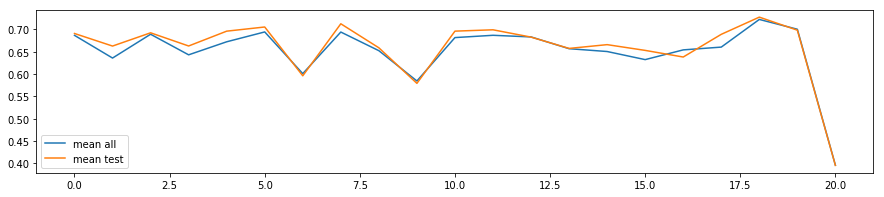

In [17]:
plt.plot([x[0] for x in dense_user_entropy_data[404]], label='mean all')
plt.plot([x[1] for x in dense_user_entropy_data[404]], label='mean test')
plt.legend()
_ = plt.show()

---

In [18]:
N_STEPS_FINETUNE = 200 # 20 doesn't seem to make a difference in entropy.

spars_user_entropy_data = {}

for _, user in spars_users[:5]:
    entropy_data = []
    
    model.load(checkpoing_fname)
    %time model.train(train_mask, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
    entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
    cnt = 0
    
    mask_ = np.copy(train_mask)
    for item in np.where(test_masks[user])[0]:
        model.load(checkpoing_fname)
        mask_[user,item] = 1 # Pretend we showed this item to the user.
        model.train(mask_, n_iter=N_STEPS_FINETUNE) # TODO: SLOW (~30s)
        entropy_data.append(get_entropy_data(model, user, intended_mask=test_masks[user]))
    
        cnt += 1
        print(cnt, np.sum(test_masks[user]))
        if cnt >= 20: # DEBUG
            break
    
    spars_user_entropy_data[user] = entropy_data

INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
CPU times: user 2min 20s, sys: 22.9 s, total: 2min 43s
Wall time: 44.6 s
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
1 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
2 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
3 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
4 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
5 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
CPU times: user 2min 20s, sys: 22.9 s, total: 2min 43s
Wall time: 44.5 s
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
1 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
2 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
3 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
4 5
INFO:tensorflow:Restoring parameters from test_checkpoing_100.ckpt
5 5
INFO:tenso

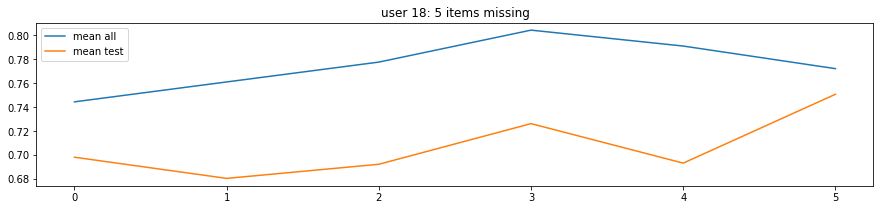

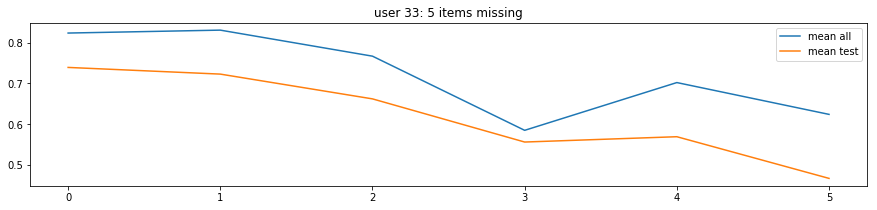

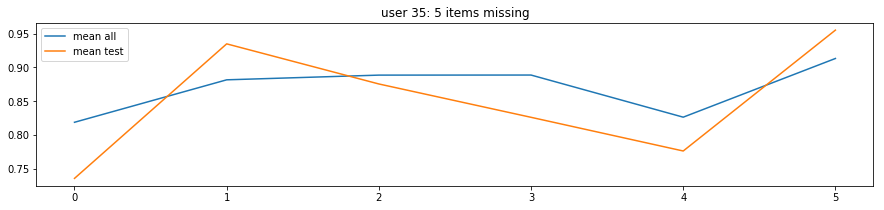

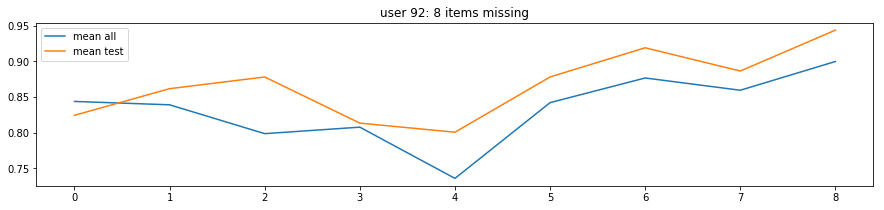

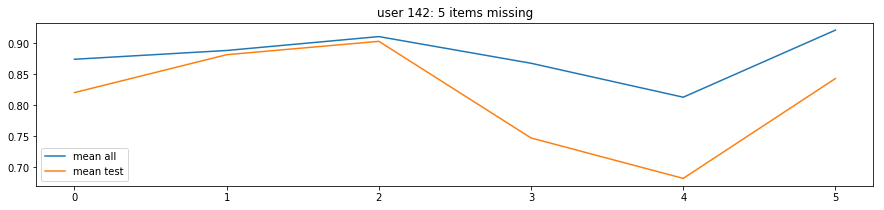

KeyError: 146

In [19]:
for _, user in spars_users[:10]:
    plt.plot([x[0] for x in spars_user_entropy_data[user]], label='mean all')
    plt.plot([x[1] for x in spars_user_entropy_data[user]], label='mean test')
    n_missing = np.sum(test_masks[user])
    plt.title("user {}: {} items missing".format(user, n_missing))
    plt.legend()
    _ = plt.show()

---